# Trap Intensity Sensitivity

Finds how the trap site center intensity depends on various parameters such as the spot transmission, relative phase between spots and background, and iris radius.

Another notebook in the series of analysis of Mark's trap array design. 

In [266]:
## general imports
import numpy as np
from numpy import *
from numpy.fft import fft,fft2,fftshift,ifftshift
from scipy.optimize import curve_fit
from scipy.special import j0, j1
from matplotlib import colors
import matplotlib.pyplot as plt
from time import time
from random import random as rand

## local imports
import os,sys
sys.path.append(os.path.join("..","."))
from field_funcs import * # my helper functions
from physconsts import *
from simfuncs import *

## make the display wide
from IPython.core.display import HTML, display, Image
display(HTML("<style>.container{width:100% !important;}</style>"))

# image path 
imagedir = os.path.join('..','images')
print("images saved in", imagedir)

# for matplotlib labels
fontsize=14

def savefigure(fname):
    assert len(fname.split(".")), "fname should have exactly one period '.', before the extension"
    fname = fname.split('.')
    fname = fname[0] + '_' +str(int(10000*rand())) + '.' + fname[1]
    filepath = os.path.join(imagedir,fname)
    plt.savefig(filepath, bbox_inches='tight')
    print("saved file to",filepath)

images saved in ..\images


## Spot reflection

No phase difference between disk and background, but check the dependence of the trap depth on spot reflection.

In [3]:
## physics and lens params
# lengths in m

lmbda = 8.05e-7
nu0 = c/lmbda
k = 2*pi/lmbda

f1 = 0.5 # lens focal length
f2 = 0.005
A0 = 1 # input field amplitude

# input mask params
a = 1e-4 # spot radius
dx = 4.3*a # grid periodicity
dy = dx
b = f1*3.8317/(a*k) # fourier plane filter radius
xnum1 = ynum1 = 10 # number of grid points in each dimension

## output field Talbot lengths
Lx2 = f2*dx/f1 # output array periodicity
Ly2 = f2*dy/f1
zTalbotx = 2*Lx2**2/lmbda 
zTalboty = 2*Ly2**2/lmbda 

## print out parameters
print("length units are m:")
print(f'b={b:0.6f}, a={a}, dx={dx}, dy={dy}, xnum={xnum1}, ynum={ynum1}')
print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')

length units are m:
b=0.002455, a=0.0001, dx=0.00043, dy=0.00043, xnum=10, ynum=10
zTalbotx=0.000046, zTalboty=0.000046


(-3.141592653589793, 3.141592653589793)

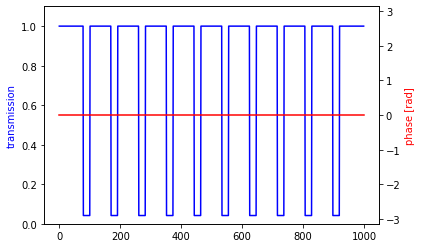

In [5]:
## create a mask that induces a phase difference between spots and background

pts = 1000
phi_std=None # [rad]
pos_std=None
T_aper = 0.082
r_aper = sqrt(1-T) # aperture reflectivity
t_plate = 1 # plate transmissivity
# the mask with desired transmission properties
mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=sqrt(T), plate=t_plate)

# spot phase mask.
spot_phases, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1, plate=0)
phi = 0
spot_phases *= exp(-1j*phi)

# mask with 1's on background, 0's on spots.
complement, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=0, plate=1)

phase_mask = spot_phases + complement

# finally, apply the phases to the transmission mask
field0 = mask*phase_mask

fig,ax1 = plt.subplots()
ax1.plot(range(pts), abs(field0[800,:]),color='blue')
ax1.set_ylabel("transmission",color='blue')
ax1.set_ylim((0,1.1))

ax2 = ax1.twinx()
ax2.plot(range(pts), angle(field0[800,:]),color='red')
ax2.set_ylabel("phase [rad]",color='red')
ax2.set_ylim((-pi,pi))

# plt.imshow(real(conjugate(field0)*field0))

In [31]:
field0[800,:].shape

(1000,)

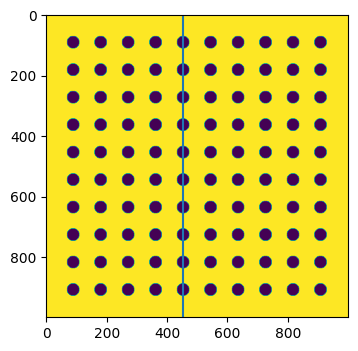

In [6]:
plt.close()
fig,ax = plt.subplots(dpi=100)
plt.imshow(abs(field0))
ax.axvline(453)

In [78]:
linspace(0.05,0.12,7)

array([0.05      , 0.06166667, 0.07333333, 0.085     , 0.09666667,
       0.10833333, 0.12      ])

In [91]:
sqrt(T),1-sqrt(1-T)

(0.34641016151377546, 0.061916848035314054)

In [89]:
# input mask
pts = 1000
phi_std=None # [rad]
pos_std=None

phi = 0
T_aper = 0.082
r_aper = sqrt(1-T) # aperture reflectivity
t_plate = 1 # plate transmissivity
mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=sqrt(T_aper), plate=t_plate)
complement, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=0, plate=1)

# range of spot phases wrt to background
numsteps = 7
T_steps = linspace(0.05,0.12,numsteps) 
I2max = 1

z2 = f2 # output plane

xslice = 453 # x coordinate of the slice
slices_soln = empty((pts,numsteps),dtype=float) 

for i,T in enumerate(T_steps):

    # calculate the input field
    print(f'T={T}')
    mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=sqrt(T), plate=t_plate)
    
    # add phases to input field 
#     spot_phases, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1, plate=0)
#     spot_phases *= exp(-1j*phi*pi/180)
#     phase_mask = spot_phases + complement

    # finally, apply the phases to the transmission mask
#     field0 = mask*phase_mask
    field0 = mask

    # FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
    padding= int(pts/2) 
    rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
    field1,x1pts = lens_xform(f1,field0,b,f1,k,x0pts,rr0,padding,masked=False,padval=1,
                              logging=False)

    # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
    rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
    field2,x2pts = lens_xform(z2,field1,b,f2,k,x1pts,rr1,padding,masked=True,
                              logging=False)
    
#     if phi == 0:
#         I2max = max(abs(field2[:,xslice])**2)
#         print("obtained normalization factor")
    
    slices_soln[:,i] = abs(field2[:,xslice])**2
    print(f"step {i} completed")
    
I2max = max(abs(field2[:,xslice])**2)
for i in range(numsteps):
    slices_soln[:,i] /= I2max

T=0.05
step 0 completed
T=0.06166666666666667
step 1 completed
T=0.07333333333333333
step 2 completed
T=0.08499999999999999
step 3 completed
T=0.09666666666666666
step 4 completed
T=0.10833333333333334
step 5 completed
T=0.12
step 6 completed


In [61]:
[T_steps[i] for i in [1,3,5,7,10]]

[0.08272727272727273,
 0.1741818181818182,
 0.2656363636363636,
 0.35709090909090907,
 0.49427272727272725]

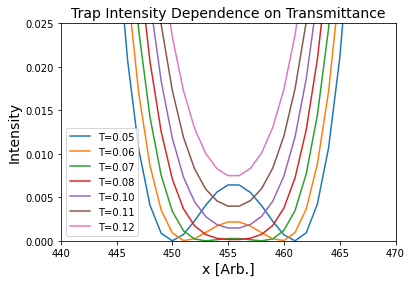

In [90]:
savefig=False
fig,ax = plt.subplots()
for i in range(numsteps):
    ax.plot(range(pts),slices_soln[:,i],label=f'T={T_steps[i]:0.2f}')
ax.set_title("Trap Intensity Dependence on Transmittance",fontsize=fontsize)
ax.set_xlabel("x [Arb.]",fontsize=fontsize)
ax.set_ylabel("Intensity",fontsize=fontsize)
ax.set_ylim((0,0.025))
ax.set_xlim((440,470))
ax.legend()
if savefig:
    fname = f"plot_trap_profile_spot_T_dependence_{int(100*t_plate)}_T_steps_{int(100*T_steps[0])}_{int(100*T_steps[-1])}_{numsteps}pts.png"
    savefigure(fname)

## Spot phases

In [5]:
## physics and lens params
# lengths in m

lmbda = 8.05e-7
nu0 = c/lmbda
k = 2*pi/lmbda

f1 = 0.5 # lens focal length
f2 = 0.005
A0 = 1 # input field amplitude

# input mask params
a = 1e-4 # spot radius
dx = 4.3*a # grid periodicity
dy = dx
b = f1*3.8317/(a*k) # fourier plane filter radius
xnum1 = ynum1 = 10 # number of grid points in each dimension

## output field Talbot lengths
Lx2 = f2*dx/f1 # output array periodicity
Ly2 = f2*dy/f1
zTalbotx = 2*Lx2**2/lmbda 
zTalboty = 2*Ly2**2/lmbda 

## print out parameters
print("length units are m:")
print(f'b={b:0.6f}, a={a}, dx={dx}, dy={dy}, xnum={xnum1}, ynum={ynum1}')
print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')

length units are m:
b=0.002455, a=0.0001, dx=0.00043, dy=0.00043, xnum=10, ynum=10
zTalbotx=0.000046, zTalboty=0.000046


(-3.141592653589793, 3.141592653589793)

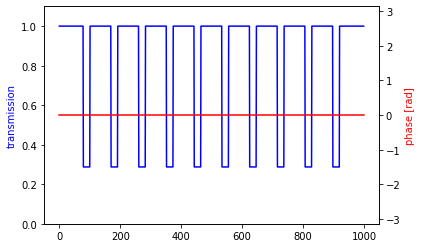

In [6]:
## create a mask that induces a phase difference between spots and background

pts = 1000
phi_std=None # [rad]
pos_std=None
T_aper = 0.0827
r_aper = sqrt(1-T_aper) # aperture reflectivity
t_plate = 1 # plate transmissivity
# the mask with desired transmission properties
mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=sqrt(T_aper), plate=t_plate)

# spot phase mask.
spot_phases, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1, plate=0)
phi = 0
spot_phases *= exp(-1j*phi)

# mask with 1's on background, 0's on spots.
complement, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=0, plate=1)

phase_mask = spot_phases + complement

# finally, apply the phases to the transmission mask
field0 = mask*phase_mask

fig,ax1 = plt.subplots()
ax1.plot(range(pts), abs(field0[800,:]),color='blue')
ax1.set_ylabel("transmission",color='blue')
ax1.set_ylim((0,1.1))

ax2 = ax1.twinx()
ax2.plot(range(pts), angle(field0[800,:]),color='red')
ax2.set_ylabel("phase [rad]",color='red')
ax2.set_ylim((-pi,pi))

# plt.imshow(real(conjugate(field0)*field0))

In [31]:
field0[800,:].shape

(1000,)

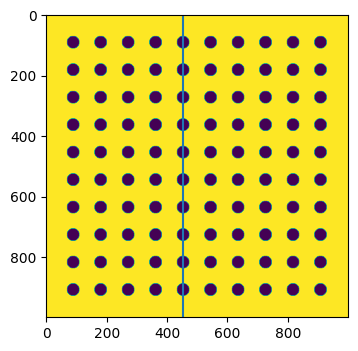

In [6]:
plt.close()
fig,ax = plt.subplots(dpi=100)
plt.imshow(abs(field0))
ax.axvline(453)

In [78]:
linspace(0.05,0.12,7)

array([0.05      , 0.06166667, 0.07333333, 0.085     , 0.09666667,
       0.10833333, 0.12      ])

In [91]:
sqrt(T),1-sqrt(1-T)

(0.34641016151377546, 0.061916848035314054)

In [129]:
# input mask
pts = 1000
phi_std=None # [rad]
pos_std=None

phi = 0
T_aper = 0.0827
r_aper = sqrt(1-T) # aperture reflectivity
t_plate = 1 # plate transmissivity
mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=sqrt(T_aper), plate=t_plate)
complement, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=0, plate=1)

# range of spot phases wrt to background
numsteps = 5
phi_steps = linspace(0,20,numsteps) 
I2max = 1

z2 = f2 # output plane

xslice = 453 # x coordinate of the slice
slices_soln = empty((pts,numsteps),dtype=float) 

for i,phi in enumerate(phi_steps):

    # calculate the input field
    print(f'phi={phi}')
    mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=sqrt(T_aper), plate=t_plate)
    
#     add phases to input field 
    spot_phases, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1, plate=0)
    spot_phases *= exp(-1j*phi*pi/180)
    phase_mask = spot_phases + complement

#     finally, apply the phases to the transmission mask
    field0 = mask*phase_mask
#     field0 = mask

    # FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
    padding= int(pts/2) 
    rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
    field1,x1pts = lens_xform(f1,field0,b,f1,k,x0pts,rr0,padding,masked=False,padval=1,
                              logging=False)

    # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
    rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
    field2,x2pts = lens_xform(z2,field1,b,f2,k,x1pts,rr1,padding,masked=True,
                              logging=False)
    
    if phi == 0:
        I2max = max(abs(field2[:,xslice])**2)
        print("obtained normalization factor")
    
    slices_soln[:,i] = abs(field2[:,xslice])**2
    print(f"step {i} completed")
    
# I2max = max(abs(field2[:,xslice])**2)
for i in range(numsteps):
    slices_soln[:,i] /= I2max

phi=0.0
obtained normalization factor
step 0 completed
phi=5.0
step 1 completed
phi=10.0
step 2 completed
phi=15.0
step 3 completed
phi=20.0
step 4 completed


saved file to ..\images\plot_trap_profile_spot_t_plate_100_T_aper_8_phi_steps_0_20_5pts.png


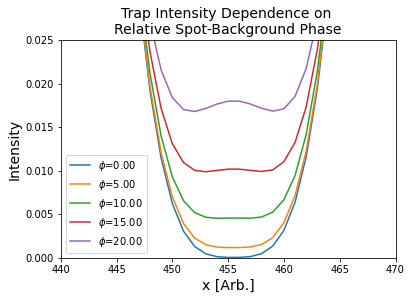

In [133]:
savefig=True
fig,ax = plt.subplots()
for i in range(numsteps):
    ax.plot(range(pts),slices_soln[:,i],label=f'$\phi$={phi_steps[i]:0.2f}')
ax.set_title("Trap Intensity Dependence on \nRelative Spot-Background Phase",fontsize=fontsize)
ax.set_xlabel("x [Arb.]",fontsize=fontsize)
ax.set_ylabel("Intensity",fontsize=fontsize)
ax.set_ylim((0,0.025))
ax.set_xlim((440,470))
ax.legend()
if savefig:
    fname = f"plot_trap_profile_spot_t_plate_{int(100*t_plate)}_T_aper_{int(100*T_aper)}_phi_steps_{int(phi_steps[0]/pi)}_{int(phi_steps[-1])}_{numsteps}pts.png"
    savefigure(fname)

In [101]:
f"plot_trap_min_vs_spot_phase_tplate{int(100*t_plate)}_rspot{int(100*(1-r_aper))}_{numsteps}pts.png"

'plot_trap_min_vs_spot_phase_tplate80_rspot25_101pts.png'

ValueError: x and y must have same first dimension, but have shapes (3,) and (5,)

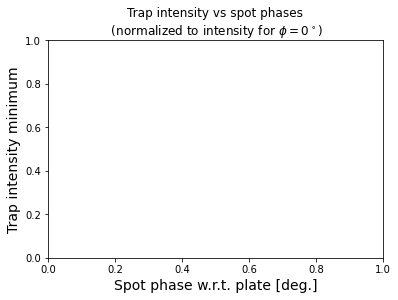

In [134]:
savefig=False
fig,ax = plt.subplots()
ax.set_title(r"Trap intensity vs spot phases" + "\n (normalized to intensity for $\phi=0^\circ$)" )
ax.set_xlabel("Spot phase w.r.t. plate [deg.]",fontsize=fontsize)
ax.set_ylabel(r"Trap intensity minimum",fontsize=fontsize)
ax.plot(phase_steps, [slices_soln[455,i] for i in range(numsteps)],color='crimson')
if savefig:
    fname = f"plot_trap_min_vs_spot_phase_tplate{int(100*t_plate)}_rspot{int(100*(1-r_aper))}_pi{abs(int(phase_steps[0]))}_pf{abs(int(phase_steps[-1]))}_{numsteps}pts.png"
    savefigure(fname)

## Iris radius and spot phase

In [5]:
## physics and lens params
# lengths in m

lmbda = 8.08e-7
nu0 = c/lmbda
k = 2*pi/lmbda

f1 = 0.5 # lens focal length
f2 = 0.005
A0 = 1 # input field amplitude

# input mask params
a = 1e-4 # spot radius
dx = 4.3*a # grid periodicity
dy = dx
b = f1*3.8317/(a*k) # fourier plane filter radius
xnum1 = ynum1 = 10 # number of grid points in each dimension

## output field Talbot lengths
Lx2 = f2*dx/f1 # output array periodicity
Ly2 = f2*dy/f1
zTalbotx = 2*Lx2**2/lmbda
zTalboty = 2*Ly2**2/lmbda

## print out parameters
print("length units are m:")
print(f'b={b:0.6f}, a={a}, dx={dx}, dy={dy}, xnum={xnum1}, ynum={ynum1}')
print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')

length units are m:
b=0.002464, a=0.0001, dx=0.00043, dy=0.00043, xnum=10, ynum=10
zTalbotx=0.000046, zTalboty=0.000046


(-3.141592653589793, 3.141592653589793)

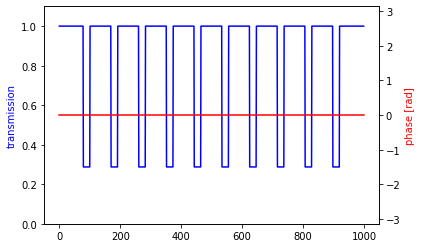

In [6]:
## create a mask that induces a phase difference between spots and background

pts = 1000
phi_std=None # [rad]
pos_std=None
T_aper = 0.0827
r_aper = sqrt(1-T_aper) # aperture reflectivity
t_plate = 1 # plate transmissivity
# the mask with desired transmission properties
mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=sqrt(T_aper), plate=t_plate)

# spot phase mask.
spot_phases, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1, plate=0)
phi = 0
spot_phases *= exp(-1j*phi)

# mask with 1's on background, 0's on spots.
complement, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=0, plate=1)

phase_mask = spot_phases + complement

# finally, apply the phases to the transmission mask
field0 = mask*phase_mask

fig,ax1 = plt.subplots()
ax1.plot(range(pts), abs(field0[800,:]),color='blue')
ax1.set_ylabel("transmission",color='blue')
ax1.set_ylim((0,1.1))

ax2 = ax1.twinx()
ax2.plot(range(pts), angle(field0[800,:]),color='red')
ax2.set_ylabel("phase [rad]",color='red')
ax2.set_ylim((-pi,pi))

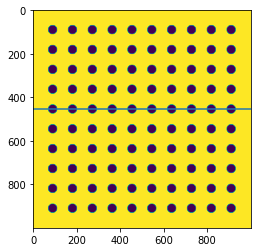

In [21]:
plt.imshow(real(conjugate(field0)*field0))
plt.axhline(xslice)

In [162]:
# input mask
pts = 1000
phi_std=None # [rad]
pos_std=None

phi = 0
T_aper = 0.49 # a far from optimal reflectivity value
r_aper = sqrt(1-T) # aperture reflectivity
t_plate = 1 # plate transmissivity
mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=sqrt(T_aper), plate=t_plate)
complement, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=0, plate=1)

# range of spot phases wrt to background
numsteps = 21
b_steps = linspace(0.5*b,1.5*b,numsteps) 
I2max = 1

z2 = f2 # output plane

xslice = 453 # x coordinate of the slice
slices_soln = empty((pts,numsteps),dtype=float) 

for i,bs in enumerate(b_steps):

    # calculate the input field
    print(f'b={bs*1e3}mm')
    mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=sqrt(T_aper), plate=t_plate)
    
#     add phases to input field 
#     spot_phases, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1, plate=0)
#     spot_phases *= exp(-1j*phi*pi/180)
#     phase_mask = spot_phases + complement

#     finally, apply the phases to the transmission mask
#     field0 = mask*phase_mask
    field0 = mask

    # FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
    padding= int(pts/2) 
    rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
    field1,x1pts = lens_xform(f1,field0,bs,f1,k,x0pts,rr0,padding,masked=False,padval=1,
                              logging=False)

    # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
    rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
    field2,x2pts = lens_xform(z2,field1,bs,f2,k,x1pts,rr1,padding,masked=True,
                              logging=False)
    
    if bs == b:
        I2max = max(abs(field2[:,xslice])**2)
        print("obtained normalization factor")
    
    slices_soln[:,i] = abs(field2[:,xslice])**2
    print(f"step {i} completed")
    
I2max = max(abs(field2[:,xslice])**2)
for i in range(numsteps):
    slices_soln[:,i] /= I2max

b=1.2272909158334961mm
step 0 completed
b=1.3500200074168458mm
step 1 completed
b=1.4727490990001955mm
step 2 completed
b=1.595478190583545mm
step 3 completed
b=1.7182072821668946mm
step 4 completed
b=1.8409363737502442mm
step 5 completed
b=1.9636654653335937mm
step 6 completed
b=2.086394556916943mm
step 7 completed
b=2.209123648500293mm
step 8 completed
b=2.3318527400836424mm
step 9 completed
b=2.4545818316669923mm
obtained normalization factor
step 10 completed
b=2.5773109232503417mm
step 11 completed
b=2.7000400148336916mm
step 12 completed
b=2.822769106417041mm
step 13 completed
b=2.9454981980003905mm
step 14 completed
b=3.06822728958374mm
step 15 completed
b=3.19095638116709mm
step 16 completed
b=3.3136854727504392mm
step 17 completed
b=3.436414564333789mm
step 18 completed
b=3.5591436559171385mm
step 19 completed
b=3.6818727475004884mm
step 20 completed


In [ ]:
[]

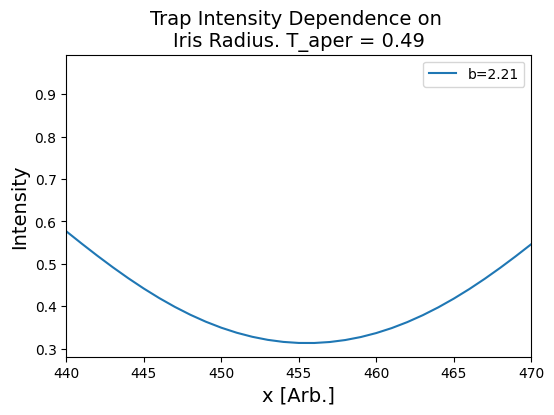

In [171]:
savefig=False
fig,ax = plt.subplots(dpi=100)
for i in [8]:
    ax.plot(range(pts),slices_soln[:,i],label=f'b={b_steps[i]*1e3:0.2f}')
ax.set_title("Trap Intensity Dependence on \nIris Radius. T_aper = 0.49",fontsize=fontsize)
ax.set_xlabel("x [Arb.]",fontsize=fontsize)
ax.set_ylabel("Intensity",fontsize=fontsize)
# ax.set_ylim((0,0.025))
ax.set_xlim((440,470))
ax.legend()
if savefig:
    fname = f"plot_trap_profile_spot_t_plate_{int(100*t_plate)}_T_aper_{int(100*T_aper)}_b_steps_{int(b_steps[0]*1e6)}_{int(b_steps[-1])}um_{numsteps}pts.png"
    savefigure(fname)

In [174]:
# input mask
pts = 1000
phi_std=None # [rad]
pos_std=None

phi = 0
bs = 0.00221
ta = 0.49
tb = 1 # background transmission amp.
mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=ta, plate=tb)
complement, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=0, plate=1)

# range of spot phases wrt to background
numsteps = 11
phi_steps = linspace(0,45,numsteps) 
I2max = 1

z2 = f2 # output plane

xslice = 453 # x coordinate of the slice
slices_soln = empty((pts,numsteps),dtype=float)

for i,phi in enumerate(phi_steps):

    # calculate the input field
    print(f'phi={phi}')
    mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=sqrt(T_aper), plate=t_plate)
    
#     add phases to input field 
    spot_phases, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1, plate=0)
    spot_phases *= exp(-1j*phi*pi/180)
    phase_mask = spot_phases + complement

#     finally, apply the phases to the transmission mask
    field0 = mask*phase_mask
#     field0 = mask

    # FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
    padding= int(pts/2) 
    rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
    field1,x1pts = lens_xform(f1,field0,bs,f1,k,x0pts,rr0,padding,masked=False,padval=1,
                              logging=False)

    # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
    rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
    field2,x2pts = lens_xform(z2,field1,bs,f2,k,x1pts,rr1,padding,masked=True,
                              logging=False)
    
    if phi == 0:
        I2max = max(abs(field2[:,xslice])**2)
        print("obtained normalization factor")
    
    slices_soln[:,i] = abs(field2[:,xslice])**2
    print(f"step {i} completed")
    
# I2max = max(abs(field2[:,xslice])**2)
for i in range(numsteps):
    slices_soln[:,i] /= I2max

phi=0.0
obtained normalization factor
step 0 completed
phi=4.5
step 1 completed
phi=9.0
step 2 completed
phi=13.5
step 3 completed
phi=18.0
step 4 completed
phi=22.5
step 5 completed
phi=27.0
step 6 completed
phi=31.5
step 7 completed
phi=36.0
step 8 completed
phi=40.5
step 9 completed
phi=45.0
step 10 completed


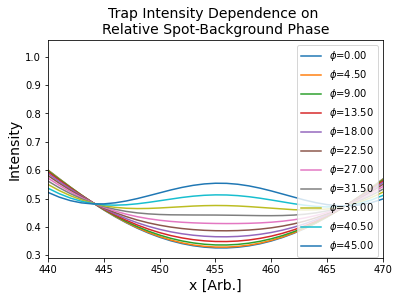

In [179]:
savefig=False
fig,ax = plt.subplots()
for i in range(numsteps):
    ax.plot(range(pts),slices_soln[:,i],label=f'$\phi$={phi_steps[i]:0.2f}')
ax.set_title("Trap Intensity Dependence on \nRelative Spot-Background Phase",fontsize=fontsize)
ax.set_xlabel("x [Arb.]",fontsize=fontsize)
ax.set_ylabel("Intensity",fontsize=fontsize)
# ax.set_ylim((0,0.025))
ax.set_xlim((440,470))
ax.legend()
if savefig:
    fname = f"plot_trap_profile_spot_b_{int(1e6*bs)}us_t_plate_{int(100*t_plate)}_T_aper_{int(100*T_aper)}_phi_steps_{int(phi_steps[0]/pi)}_{int(phi_steps[-1])}_{numsteps}pts.png"
    savefigure(fname)

(0.0, 1.0)

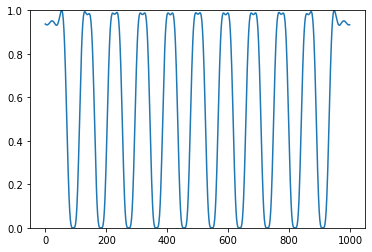

In [66]:
# sanity check before simultaneously checking phase and radius b

# input mask
pts = 1000
phi_std=None # [rad]
pos_std=None

phi = 0
bs = f1*3.8317/(a*k)
ta = 0.287119
tb = 1 # plate transmissivity
z2 = f2
xslice = 453
yslice = 455
mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=ta, plate=tb)
complement, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=0, plate=1)

# compute the correct by which to normalize
field0 = mask
# FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
padding= int(pts/2) 
rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
field1,x1pts = lens_xform(f1,field0,bs,f1,k,x0pts,rr0,padding,masked=False,padval=1,
                          logging=False)
# OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
field2,x2pts = lens_xform(z2,field1,bs,f2,k,x1pts,rr1,padding,masked=True,
                          logging=False)
I2max = max(abs(field2[:,xslice])**2) # normalize everything else to this, including the simulation that follows this

# plt.plot(range(pts),abs(field2[:,xslice])**2/max(abs(field2[:,xslice])**2))
plt.plot(range(pts),abs(field2[yslice,:])**2/max(abs(field2[:,xslice])**2))

plt.ylim((0,1))

In [69]:
# generate trap site center intensity vs iris radius and relative mask phase

numstepsy = 25
numstepsx = 25
ta = 0.287119 #sqrt(0.49)
tb = 1
phi_steps = linspace(0,180,numstepsy) # range of spot phases wrt to background
b_steps = linspace(0.6*1e-3,2.5*1e-3,numstepsx) 

z2 = f2 # output plane

xslice = 453 # x coordinate of the slice
yslice = 455
slices_soln = empty((pts,numstepsx),dtype=float)

ttotal = 0 # time tracker
soln = empty((numstepsy,numstepsx),float)
for i,phi in enumerate(phi_steps):
    for j,bs in enumerate(b_steps):

        t0 = time()
        # calculate the input field
#         print(f'phi={phi}')
        mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=ta, plate=tb)

    #     add phases to input field 
        spot_phases, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1, plate=0)
        spot_phases *= exp(-1j*phi*pi/180)
        phase_mask = spot_phases + complement

    #     finally, apply the phases to the transmission mask
        field0 = mask*phase_mask
    #     field0 = mask

        # FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
        padding= int(pts/2) 
        rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
        field1,x1pts = lens_xform(f1,field0,bs,f1,k,x0pts,rr0,padding,masked=False,padval=1,
                                  logging=False)

        # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
        rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
        field2,x2pts = lens_xform(z2,field1,bs,f2,k,x1pts,rr1,padding,masked=True,
                                  logging=False)

        soln[i,j] = abs(field2[yslice,xslice])**2
        tf = time()
        ttotal += tf - t0
        print(f"step {j + numstepsx*i} completed in {(tf-t0)/60:.2f}min")
    
# I2max = max(abs(field2[:,xslice])**2)
for i in range(numstepsx):
    slices_soln[:,i] /= I2max
print(f"simulation completed in {ttotal/60:.2f}min")

step 0 completed in 0.02min
step 1 completed in 0.06min
step 2 completed in 0.06min
step 3 completed in 0.06min
step 4 completed in 0.06min
step 5 completed in 0.06min
step 6 completed in 0.06min
step 7 completed in 0.06min
step 8 completed in 0.06min
step 9 completed in 0.06min
step 10 completed in 0.06min
step 11 completed in 0.06min
step 12 completed in 0.06min
step 13 completed in 0.06min
step 14 completed in 0.06min
step 15 completed in 0.06min
step 16 completed in 0.06min
step 17 completed in 0.06min
step 18 completed in 0.06min
step 19 completed in 0.06min
step 20 completed in 0.06min
step 21 completed in 0.06min
step 22 completed in 0.06min
step 23 completed in 0.06min
step 24 completed in 0.06min
step 25 completed in 0.06min
step 26 completed in 0.05min
step 27 completed in 0.06min
step 28 completed in 0.05min
step 29 completed in 0.05min
step 30 completed in 0.06min
step 31 completed in 0.06min
step 32 completed in 0.07min
step 33 completed in 0.06min
step 34 completed in 0.0

step 277 completed in 0.06min
step 278 completed in 0.06min
step 279 completed in 0.06min
step 280 completed in 0.06min
step 281 completed in 0.06min
step 282 completed in 0.05min
step 283 completed in 0.06min
step 284 completed in 0.06min
step 285 completed in 0.06min
step 286 completed in 0.05min
step 287 completed in 0.05min
step 288 completed in 0.06min
step 289 completed in 0.06min
step 290 completed in 0.06min
step 291 completed in 0.06min
step 292 completed in 0.06min
step 293 completed in 0.05min
step 294 completed in 0.06min
step 295 completed in 0.05min
step 296 completed in 0.05min
step 297 completed in 0.06min
step 298 completed in 0.06min
step 299 completed in 0.06min
step 300 completed in 0.05min
step 301 completed in 0.05min
step 302 completed in 0.06min
step 303 completed in 0.06min
step 304 completed in 0.06min
step 305 completed in 0.05min
step 306 completed in 0.06min
step 307 completed in 0.06min
step 308 completed in 0.06min
step 309 completed in 0.05min
step 310 c

step 551 completed in 0.05min
step 552 completed in 0.05min
step 553 completed in 0.06min
step 554 completed in 0.06min
step 555 completed in 0.06min
step 556 completed in 0.06min
step 557 completed in 0.05min
step 558 completed in 0.06min
step 559 completed in 0.05min
step 560 completed in 0.06min
step 561 completed in 0.06min
step 562 completed in 0.06min
step 563 completed in 0.06min
step 564 completed in 0.06min
step 565 completed in 0.06min
step 566 completed in 0.06min
step 567 completed in 0.06min
step 568 completed in 0.06min
step 569 completed in 0.06min
step 570 completed in 0.06min
step 571 completed in 0.06min
step 572 completed in 0.06min
step 573 completed in 0.06min
step 574 completed in 0.06min
step 575 completed in 0.06min
step 576 completed in 0.05min
step 577 completed in 0.05min
step 578 completed in 0.06min
step 579 completed in 0.06min
step 580 completed in 0.06min
step 581 completed in 0.06min
step 582 completed in 0.06min
step 583 completed in 0.06min
step 584 c

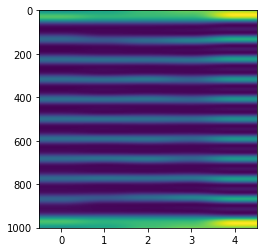

In [26]:
fig,ax = plt.subplots()
ax.imshow(slices_soln)
ax.set_aspect(0.005)

Text(0, 0.5, 'Relative mask phase [deg]')

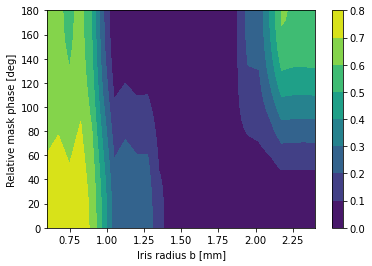

In [57]:
fig,ax = plt.subplots()
cmap = ax.contourf(soln/I2max,extent=[1e3*b_steps[0], 1e3*b_steps[-1], phi_steps[0], phi_steps[-1]]) # left right bottom top
fig.colorbar(cmap)
# ax.set_aspect(.01)
ax.set_xlabel('Iris radius b [mm]')
ax.set_ylabel('Relative mask phase [deg]')
# savefigure(f'min_ta_{int(100*ta)}_phi_steps_{int(phi_steps[0])}_{int(phi_steps[-1])}_{numstepsy}pts_b_steps_{int(b_steps[0]*1e6)}_{int(b_steps[-1]*1e6)}um_{numstepsx}pts.svg')
# savefigure(f'min_T_aper_{int(100*T_aper)}_phi_steps_{int(phi_steps[0])}_{int(phi_steps[-1])}_{numstepsy}pts_b_steps_{int(b_steps[0]*1e6)}_{int(b_steps[-1]*1e6)}um_{numstepsx}pts.png')

In [42]:
(soln/I2max)[-1,-1]

1.772957407993106

wrote data to min_ta_28_phi_steps_0_180_25pts_b_steps_600_2500um_25pts.csv
saved file to ..\images\min_ta_28_phi_steps_0_180_25pts_b_steps_600_2500um_25pts.svg


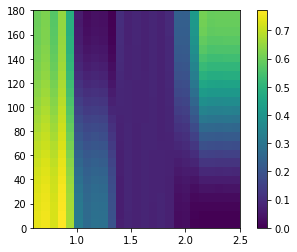

In [77]:
fig,ax = plt.subplots()
cmap = ax.imshow(soln/I2max-amin(soln/I2max),origin='lower',extent=[1e3*b_steps[0], 1e3*b_steps[-1], phi_steps[0], phi_steps[-1]]) # left right bottom top
fig.colorbar(cmap)
ax.set_aspect(1/90)
# soln_to_csv(f'min_ta_{int(100*ta)}_phi_steps_{int(phi_steps[0])}_{int(phi_steps[-1])}_{numstepsy}pts_b_steps_{int(b_steps[0]*1e6)}_{int(b_steps[-1]*1e6)}um_{numstepsx}pts.csv',soln/I2max-amin(soln/I2max),labels=None,
#             metastr='params in filename. i(rows) is phi steps, j(cols) is b steps. data[0,0] or phi=0,b=2.4e-3 correspond to the ideal 4f filtering design')
# savefigure(f'min_ta_{int(100*ta)}_phi_steps_{int(phi_steps[0])}_{int(phi_steps[-1])}_{numstepsy}pts_b_steps_{int(b_steps[0]*1e6)}_{int(b_steps[-1]*1e6)}um_{numstepsx}pts.svg')

In [71]:
amin(soln/I2max)

6.763373207462997e-07

In [89]:
b_steps[-1]/(f1/(a*k))/3.8317

1.0147218518645373

In [88]:
b

0.0024637293415986704

In [91]:
b/(3.8317*f1/(a*k))

1.0

In [84]:
(f1/(a*k))

0.0006429859700912572

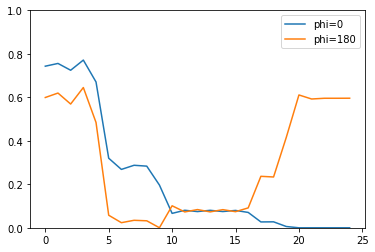

In [76]:
plt.plot((soln/I2max)[0,:],label='phi=0')
plt.plot((soln/I2max)[-1,:],label='phi=180')
plt.ylim((0,1))
plt.legend()

In [39]:
soln.shape

(25, 25)

In [38]:
soln_to_csv?

(0.1, 0.7)

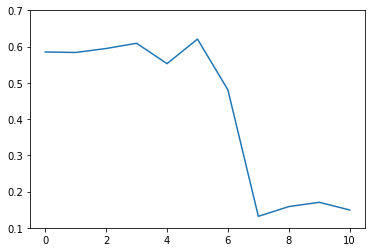

In [291]:
plt.plot(range(numstepsx),soln[-1,:]/I2max)
plt.ylim((0.1,0.7))

In [17]:
# input mask
pts = 1001
phi_std=None # [rad]
pos_std=None

phi = 140
T_aper = 0.49 # a far from optimal reflectivity value
r_aper = sqrt(1-T_aper) # aperture reflectivity
t_plate = 1 # plate transmissivity
mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=sqrt(T_aper), plate=t_plate)
complement, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=0, plate=1)
spot_phases, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1, plate=0)
spot_phases *= exp(-1j*phi*pi/180)
phase_mask = spot_phases + complement

# range of spot phases wrt to background
numsteps = 5
b_steps = linspace(1e-3,1.3e-3,numsteps)
I2max = 1

z2 = f2 # output plane

xslice = 453 # x coordinate of the slice
slices_soln = empty((pts,numsteps),dtype=float) 

for i,bs in enumerate(b_steps):

    # calculate the input field
    print(f'b={bs*1e3}mm')
    mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=sqrt(T_aper), plate=t_plate)
    
#     add phases to input field 
#     spot_phases, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1, plate=0)
#     spot_phases *= exp(-1j*phi*pi/180)
#     phase_mask = spot_phases + complement

#     finally, apply the phases to the transmission mask
    field0 = mask*phase_mask

    # FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
    padding= int(3*pts/2) 
    rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
    field1,x1pts = lens_xform(f1,field0,bs,f1,k,x0pts,rr0,padding,masked=False,padval=1,
                              logging=False)

    # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
    rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
    field2,x2pts = lens_xform(z2,field1,bs,f2,k,x1pts,rr1,padding,masked=True,
                              logging=False)
    
    if bs == b:
        I2max = max(abs(field2[:,xslice])**2)
        print("obtained normalization factor")
    
    slices_soln[:,i] = abs(field2[:,xslice])**2
    print(f"step {i} completed")
    
I2max = max(abs(field2[:,xslice])**2)
for i in range(numsteps):
    slices_soln[:,i] /= I2max

b=1.0mm
step 0 completed
b=1.075mm
step 1 completed
b=1.15mm
step 2 completed
b=1.2249999999999999mm
step 3 completed
b=1.3mm
step 4 completed


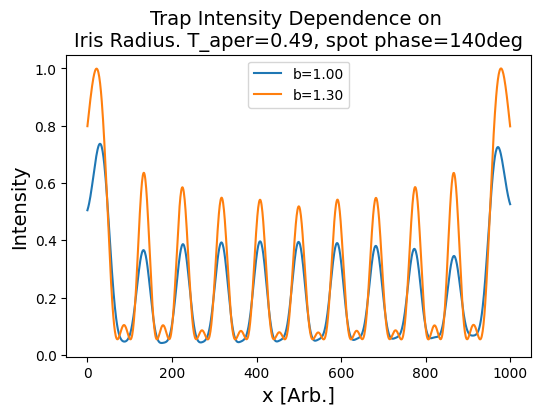

In [18]:
savefig=False
fig,ax = plt.subplots(dpi=100)
for i in [0,-1]:
    ax.plot(range(pts),slices_soln[:,i],label=f'b={b_steps[i]*1e3:0.2f}')
ax.set_title(f"Trap Intensity Dependence on \nIris Radius. T_aper={T_aper}, spot phase={phi}deg",fontsize=fontsize)
ax.set_xlabel("x [Arb.]",fontsize=fontsize)
ax.set_ylabel("Intensity",fontsize=fontsize)
# ax.set_ylim((0,0.025))
# ax.set_xlim((440,470))
ax.legend()
if savefig:
    fname = f"plot_trap_profile_spot_t_plate_{int(100*t_plate)}_phi_{phi}_T_aper_{int(100*T_aper)}_b_steps_{int(b_steps[0]*1e6)}_{int(b_steps[-1])}um_{numsteps}pts.png"
    savefigure(fname)

In [303]:
0.001/b

0.40740136959331485

## fit trap data

In [48]:
## physics and lens params
# lengths in m

lmbda = 8.05e-7
nu0 = c/lmbda
k = 2*pi/lmbda

f1 = 0.5 # lens focal length
f2 = 0.005
A0 = 1 # input field amplitude

# input mask params
a = 1e-4 # spot radius
dx = 4.3*a # grid periodicity
dy = dx
b = f1*3.8317/(a*k) # fourier plane filter radius
xnum1 = ynum1 = 20 # number of grid points in each dimension

## output field Talbot lengths
Lx2 = f2*dx/f1 # output array periodicity
Ly2 = f2*dy/f1
zTalbotx = 2*Lx2**2/lmbda
zTalboty = 2*Ly2**2/lmbda

## print out parameters
print("length units are m:")
print(f'b={b:0.6f}, a={a}, dx={dx}, dy={dy}, xnum={xnum1}, ynum={ynum1}')
print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')

length units are m:
b=0.002455, a=0.0001, dx=0.00043, dy=0.00043, xnum=35, ynum=35
zTalbotx=0.000046, zTalboty=0.000046


In [205]:
# input mask
u = 0.4
bs = u*f1*3.8317/(a*k)
I2max = 376022914566018.9

pts = 1101 #1401
phi_std=None # [rad]
pos_std=None
phi = 140

xslice = 700 # x coordinate of the slice

ta = 0.7 # a far from optimal reflectivity value
tb = 1 # plate transmissivity
mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=ta, plate=tb)
complement, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=0, plate=1)
spot_phases, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1, plate=0)
spot_phases *= exp(-1j*phi*pi/180)
phase_mask = spot_phases + complement

z2 = f2 # output plane

slices_soln = empty((pts,numsteps),dtype=float) 

# calculate the input field
print(f'b={bs*1e3}mm')
mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=sqrt(T_aper), plate=t_plate)

#     add phases to input field
#     spot_phases, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1, plate=0)
#     spot_phases *= exp(-1j*phi*pi/180)
#     phase_mask = spot_phases + complement

#     finally, apply the phases to the transmission mask
field0 = mask*phase_mask

# FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
padding= int(3*pts/2) 
rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
field1,x1pts = lens_xform(f1,field0,bs,f1,k,x0pts,rr0,padding,masked=False,padval=1,
                          logging=False)

# OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
field2,x2pts = lens_xform(z2,field1,bs,f2,k,x1pts,rr1,padding,masked=True,
                          logging=False)

Islice = abs(field2[:,xslice])**2/max(abs(field2[:,xslice])**2) #I2max

b=0.9818327326667968mm


(600.0, 800.0)

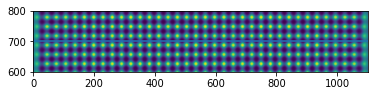

In [213]:
plt.imshow(abs(field2)**2)
plt.axhline(700)
plt.ylim((600,800))

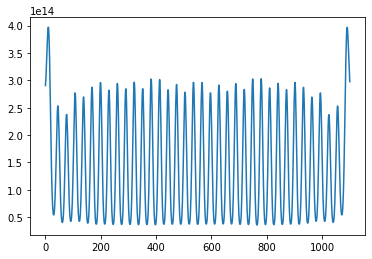

In [335]:
plt.plot(abs(field2[700])**2)
# plt.axhline(700)
# plt.ylim((600,800))

In [336]:
pts//2

550

307


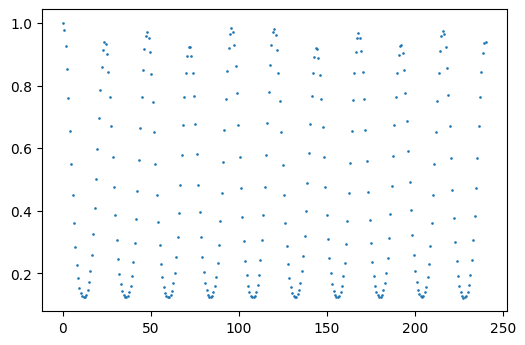

In [350]:
fig,ax = plt.subplots(dpi=100)
# trim1 = 486+150 # for 1401 pts
# trim2 = 524+150
trim1 = 413
trim2 = 381
Islice = abs(field2[700][trim1:-trim2])**2
Islice /= amax(Islice)
ax.scatter(0.785*array(range(len(Islice))),
        Islice,s=0.8)
print(len(Islice))

In [140]:
# trap intensity for 3W 805 nm laser test on 2020.08.25
file = os.path.join('paper_data','trap_profile_data_20200825.csv')
data = array(soln_from_csv(file,datatype=float))

(0.0, 305.0)

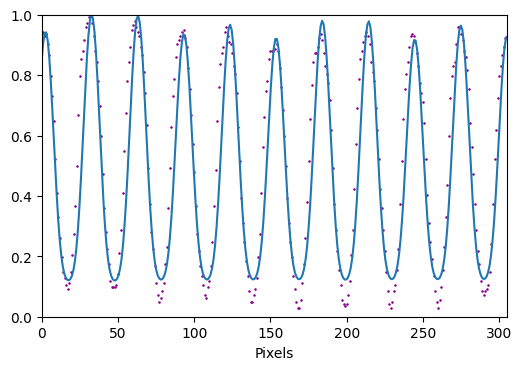

In [434]:
fig,ax = plt.subplots(dpi=100)
c1='darkmagenta' #'blueviolet'
trim1 = 739-30
trim2 = 733+25
d1 = ((data/amax(data))[trim1:-trim2])

xpts = range(len(d1))
ax.scatter(xpts,d1,linewidth=0.8,color=c1,s=1)
ax.set_xlabel("Pixels")
ax.set_ylim((0,1))

trim1 = 413-30-37
trim2 = 381+30+32
Islice = abs(field2[700][trim1:-trim2])**2
Islice /= amax(Islice)

scl=0.989
delta=-3
ax.plot(scl*array(xpts)+delta,Islice)#,s=0.8)
ax.set_xlim((0,305))
# ax.scatter(xpts,abs(Islice - d1.transpose()),s=1)

In [439]:
413-30-37,381+30+32

(346, 443)

In [440]:
## fit routine to match the data to Fresnel diffraction
# the pixel scale for the data Fresnel diffraction
# won't easily line up, so just add a scaling parameter
# to the xpts to stretch or shrink them in the fit

def model(xpts,u,phi,trim1,trim2,xslice=700):
    """
    xpts: the pixel values
    u: dimensional iris radius
    phi: the relative mask phase
    
    the number of pts set for the FFT calculation is 
    done above such that the pts per trap lines up
    with the data we are fitting. this is easier than
    making the model an actual function of the xpts 
    passed in.
    """
    # input mask
    bs = u*f1*3.8317/(a*k)

    phi_std=None # [rad]
    pos_std=None

    ta = 0.7 # a far from optimal reflectivity value
    tb = 1 # plate transmissivity
    mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=ta, plate=tb)
    complement, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=0, plate=1)
    spot_phases, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1, plate=0)
    spot_phases *= exp(-1j*phi*pi/180)
    phase_mask = spot_phases + complement

    z2 = f2 # output plane

    slices_soln = empty((pts,numsteps),dtype=float) 

    # calculate the input field
#     print(f'b={bs*1e3}mm')
    mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=sqrt(T_aper), plate=t_plate)

    # finally, apply the phases to the transmission mask
    field0 = mask*phase_mask

    # FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
    padding= int(3*pts/2) 
    rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
    field1,x1pts = lens_xform(f1,field0,bs,f1,k,x0pts,rr0,padding,masked=False,padval=1,
                              logging=False)

    # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
    rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
    field2,x2pts = lens_xform(z2,field1,bs,f2,k,x1pts,rr1,padding,masked=True,
                              logging=False)

    Islice = abs(field2[xslice][trim1:-trim2])**2
    Islice /= amax(Islice)
    return Islice #.reshape(len(Islice),1)

u = 0.4
phi = 160
fit = model(xpts,u=u,phi=phi,trim1=346,trim2=443)

saved file to ..\images\u0pt4_phi160_data_trimmed346_443_8056.svg


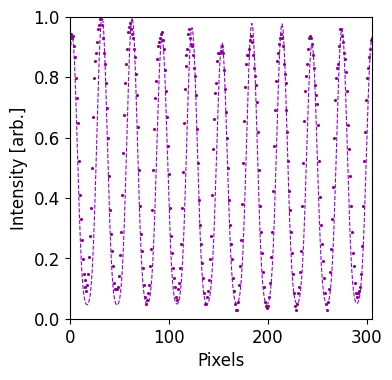

In [451]:
plt.rcParams['font.size'] = '12'
fig,ax = plt.subplots(dpi=100)
c1='darkmagenta' #'blueviolet'
xpts = range(len(d1))
ax.scatter(xpts,d1,linewidth=1,color=c1,s=1.5)
ax.set_xlabel("Pixels",fontsize=12)
ax.set_ylim((0,1))

# trim1 = 413-30
# trim2 = 381+30
# Islice = abs(field2[700][trim1:-trim2])**2
# Islice /= amax(Islice)

scl=0.989
delta=-3
ax.plot(scl*array(xpts)+delta,fit,linestyle='--',linewidth=0.8,color='darkviolet')#Islice)#,s=0.8)
# ax.scatter(xpts,abs(Islice - d1.transpose()),s=1)
ax.set_xlim((0,305))
ax.set_ylabel("Intensity [arb.]",fontsize=12)
ax.set_aspect(305)
# these trim values are actually for the numerical result
# savefigure(f"u0pt{int(10*u)}_phi{phi}_data_trimmed{trim1}_{trim2}.svg")

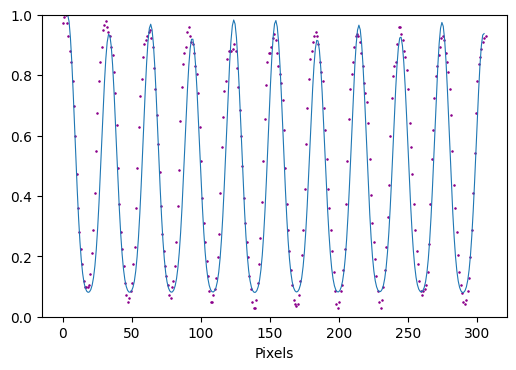

In [327]:
# test the model - plot by the data

fig,ax = plt.subplots(dpi=100)
c1='darkmagenta' #'blueviolet'
trim1 = 739
trim2 = 733
d1 = ((data/amax(data))[trim1:-trim2])

xpts = range(len(d1))
ax.scatter(xpts,d1,linewidth=0.8,color=c1,s=1)
ax.set_xlabel("Pixels")
ax.set_ylim((0,1))

scl=0.985
delta=3.5
ax.plot(scl*array(xpts)+delta,fit,linewidth=0.8)
# ax.scatter(xpts,abs(fit - squeeze(d1)),s=1)

In [333]:
soln_to_csv(f'numerical_data_compare_{int(10000*time())}.csv',data=[scl*array(xpts)+delta,fit,xpts,d1],labels=['x1','numerical','x2','data'],metastr=f'ta={ta},phi={phi},u={u},{xnum1}x{ynum1} array,{pts}pts')

wrote data to numerical_data_compare_16473582951931.csv


In [332]:
ynum1

35

In [313]:
# try scipy curvefit
# trim1 = 739
# trim2 = 733
# d1 = ((data/amax(data))[trim1:-trim2])

t0 = time()
popt, pcov = curve_fit(model,xpts,squeeze(d1),
                       bounds=([0.2,0],
                               [0.8,180]),
                       p0=[0.4,150])
u,phi = popt
print(f"u={u}, phi={phi}")
print(f"fit completed in {(time() - t0)/60:.2f}min")
fit = model(xpts,u=u,phi=phi)

KeyboardInterrupt: 

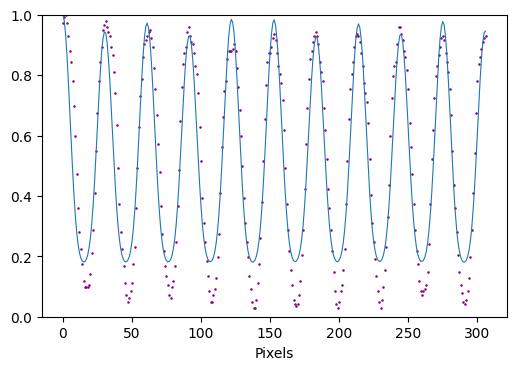

In [312]:
fig,ax = plt.subplots(dpi=100)
c1='darkmagenta' #'blueviolet'

xpts = range(len(d1))
ax.scatter(xpts,d1,linewidth=0.8,color=c1,s=1)
ax.set_xlabel("Pixels")
ax.set_ylim((0,1))

ax.plot(xpts,fit,linewidth=0.8)
# ax.scatter(xpts,abs(fit - squeeze(d1)),s=1)

In [308]:
curve_fit?

ValueError: x and y must be the same size

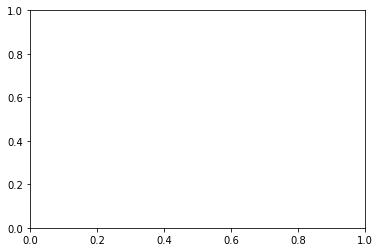

In [177]:
## compare the model to data

trim1 = 486
trim2 = 525
plt.scatter((x2pts[trim1:-trim2])*1e6,Islice[trim1:-trim2])
# plt.xlim((-20,20))
plt.ylim((0,1))

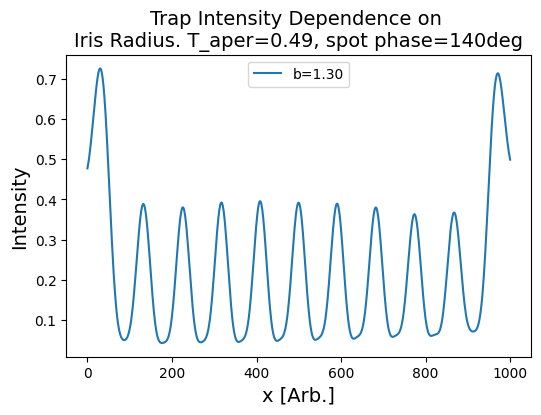

In [45]:
savefig=False
fig,ax = plt.subplots(dpi=100)
# for i in [0,-1]:
#     ax.plot(range(pts),slices_soln[:,i],label=f'b={b_steps[i]*1e3:0.2f}')
ax.plot(range(pts),abs(field2[:,xslice])**2/I2max,label=f'b={b_steps[i]*1e3:0.2f}')
ax.set_title(f"Trap Intensity Dependence on \nIris Radius. T_aper={T_aper}, spot phase={phi}deg",fontsize=fontsize)
ax.set_xlabel("x [Arb.]",fontsize=fontsize)
ax.set_ylabel("Intensity",fontsize=fontsize)
# ax.set_ylim((0,0.025))
# ax.set_xlim((440,470))
ax.legend()
if savefig:
    fname = f"plot_trap_profile_spot_t_plate_{int(100*t_plate)}_phi_{phi}_T_aper_{int(100*T_aper)}_b_steps_{int(b_steps[0]*1e6)}_{int(b_steps[-1])}um_{numsteps}pts.png"
    savefigure(fname)

In [43]:
1e-3/(f1*3.8317/(a*k))

0.40740136959331485